In [20]:
!pip install matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 12.0 MB/s eta 0:00:0000:0100:01


Player 1 Store: 0 | 4 4 4 4 4 4
4 4 4 4 4 4 | Player 2 Store: 0


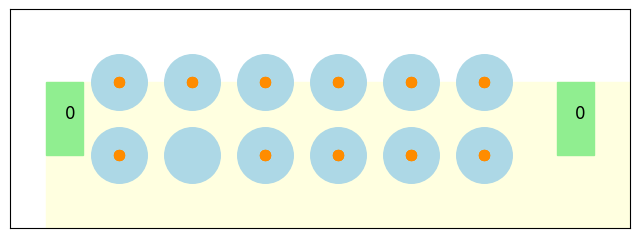

Best move determined by MCTS: 1
Chosen action by Q-learning agent: 4


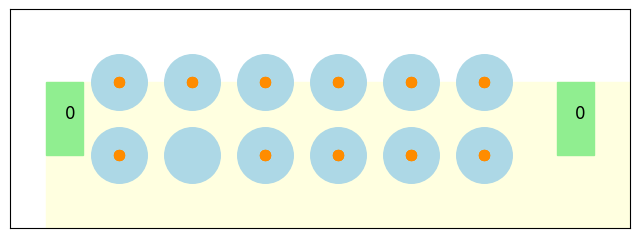

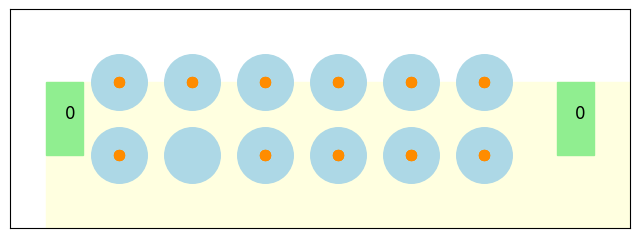

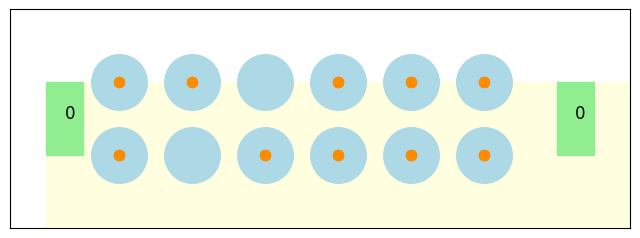

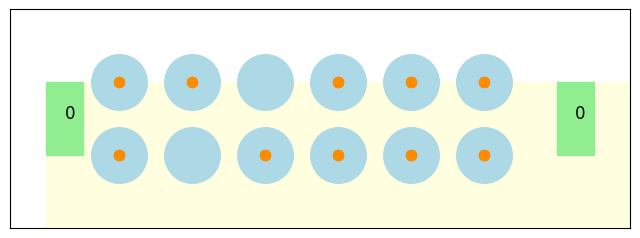

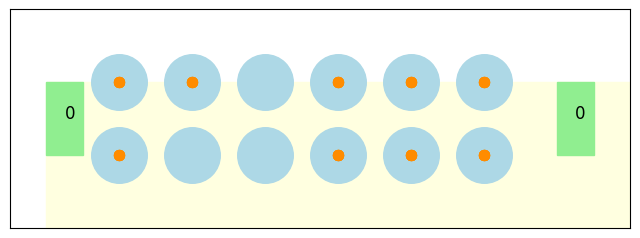

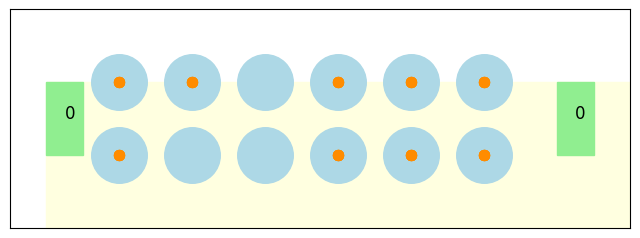

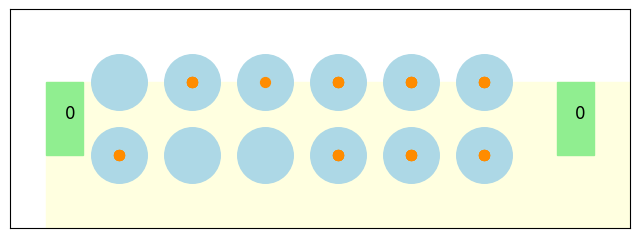

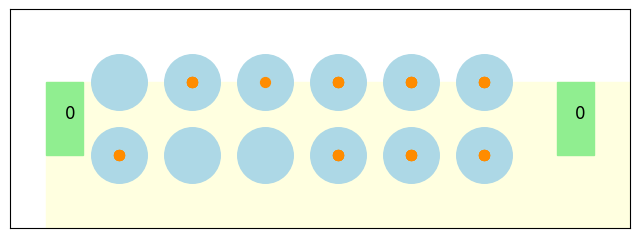

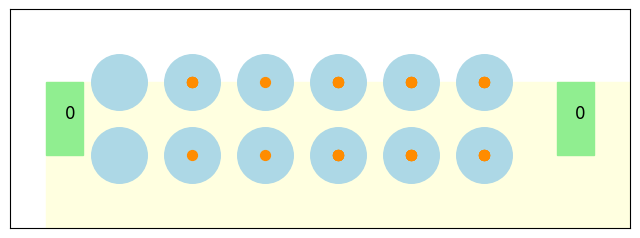

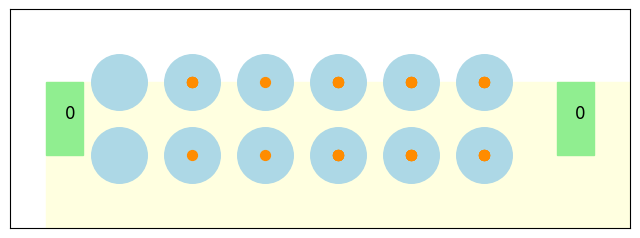

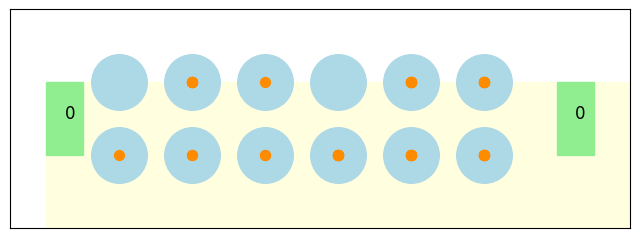

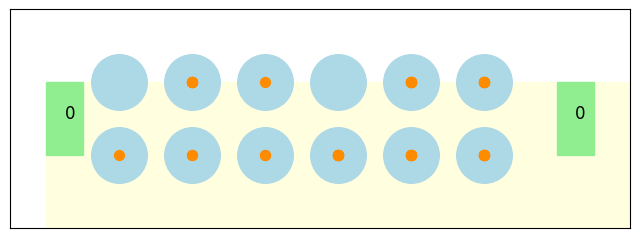

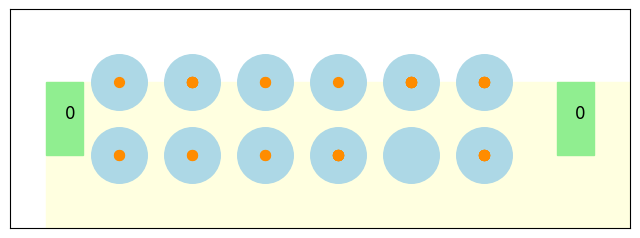

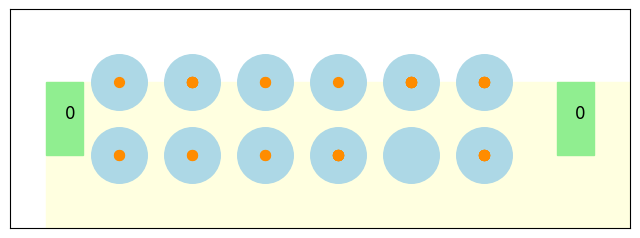

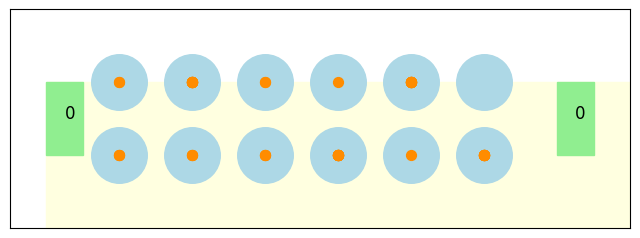

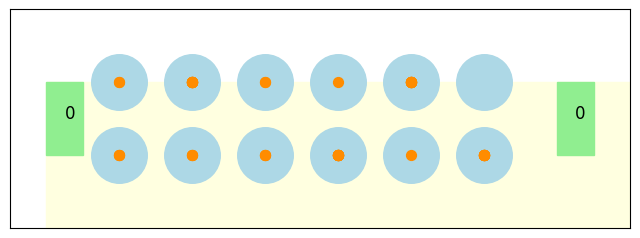

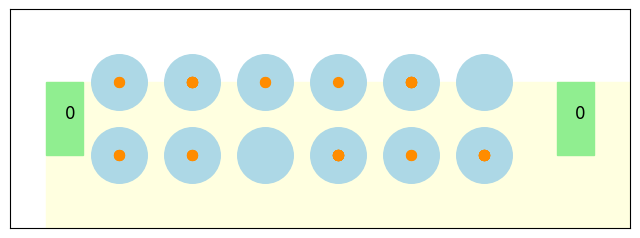

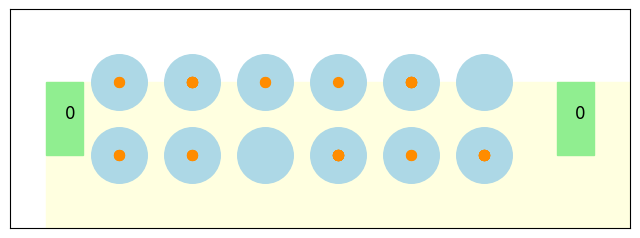

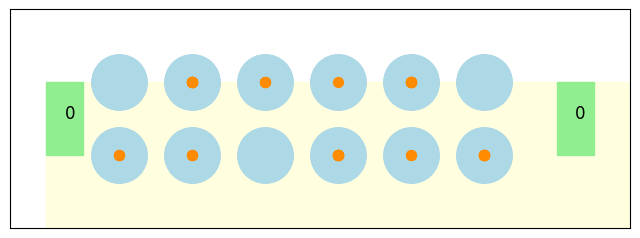

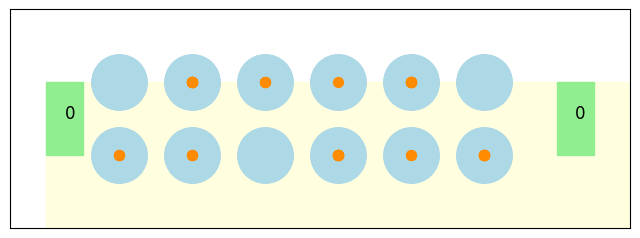

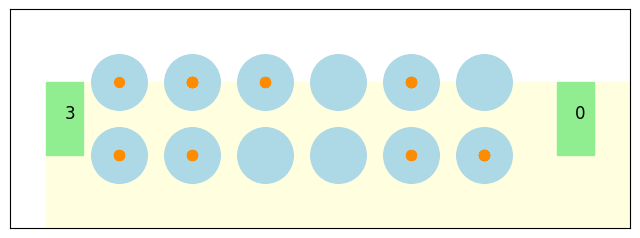

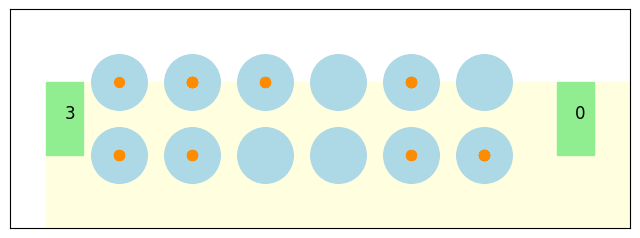

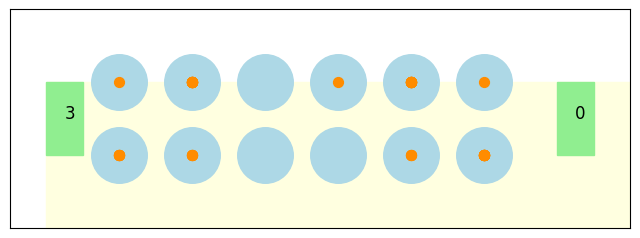

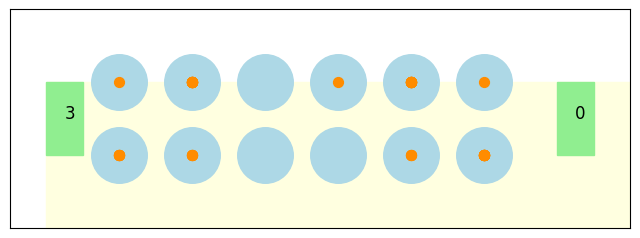

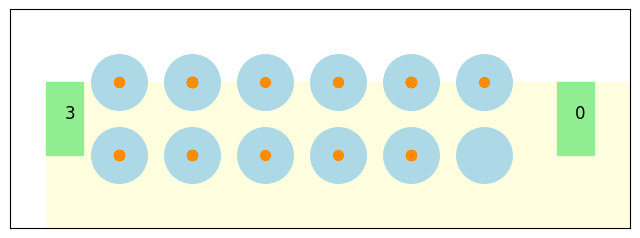

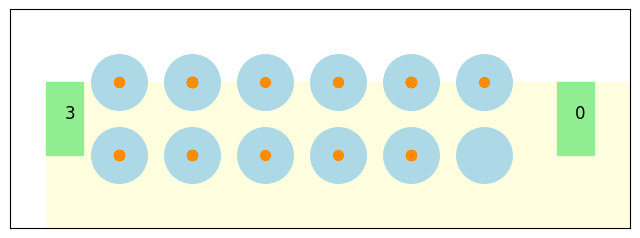

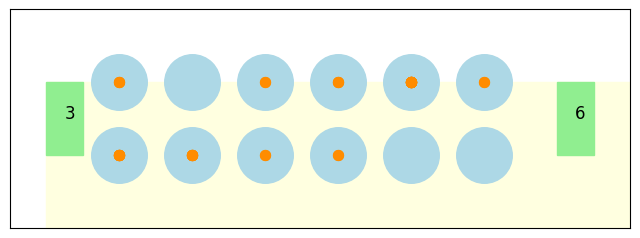

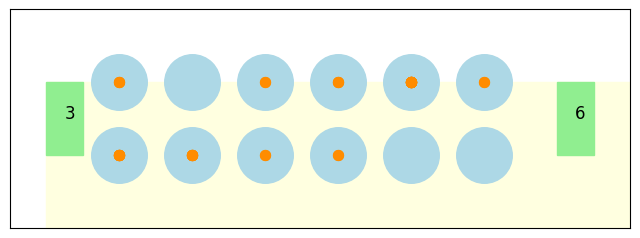

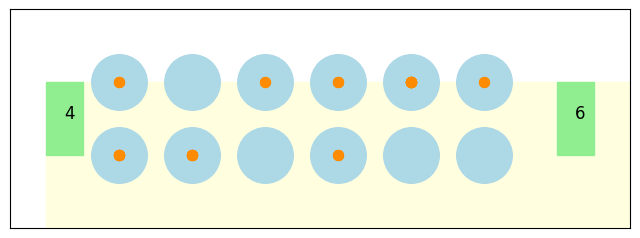

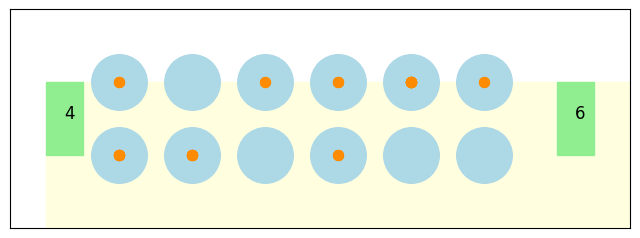

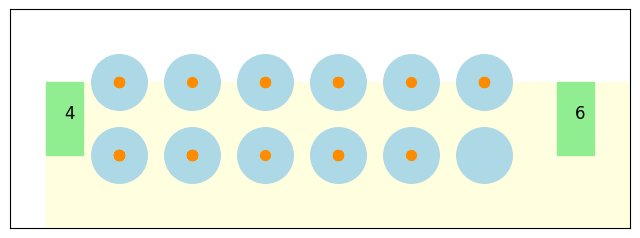

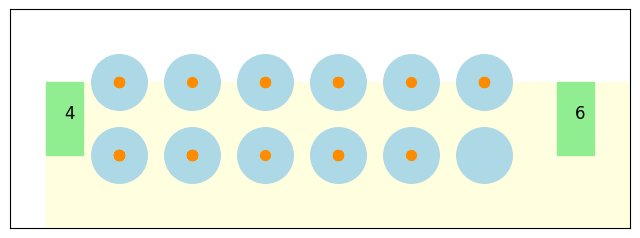

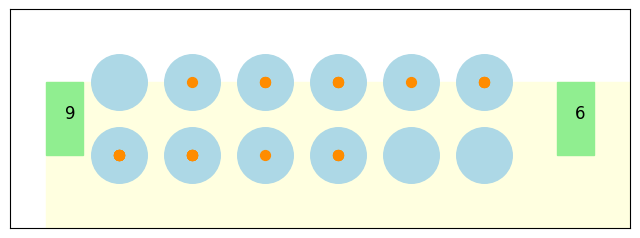

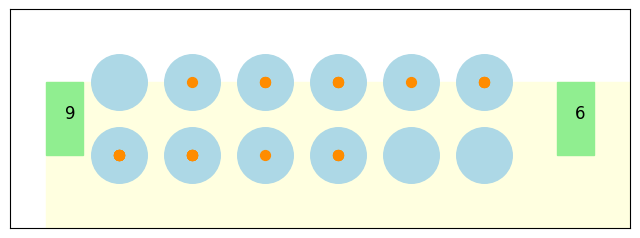

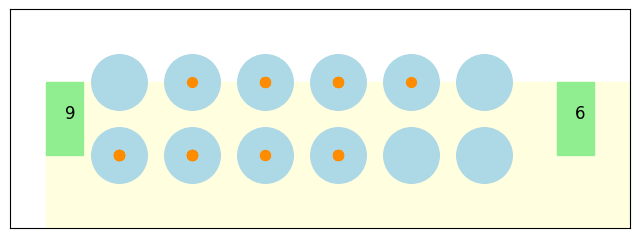

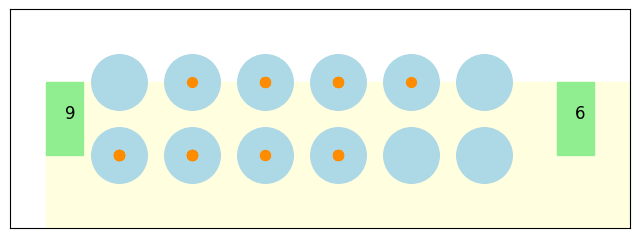

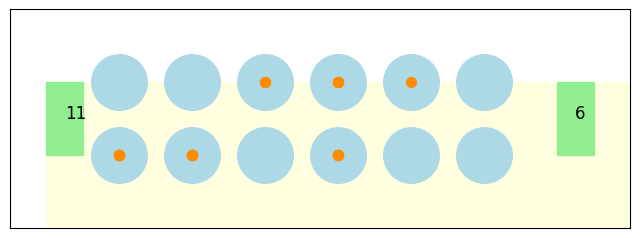

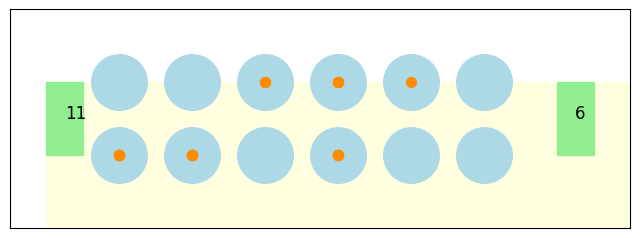

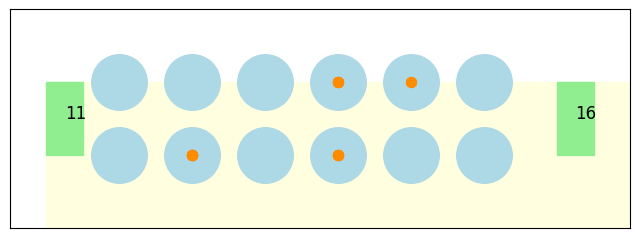

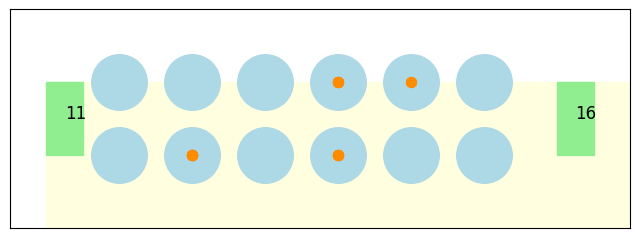

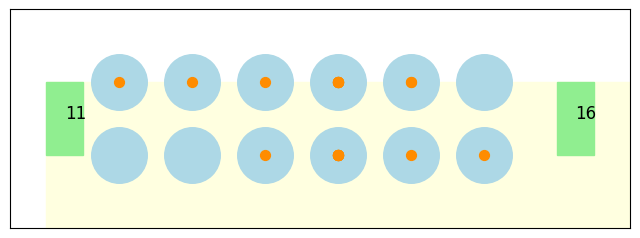

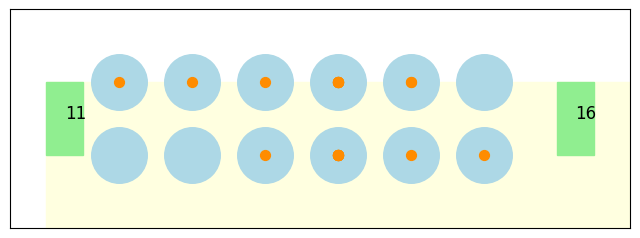

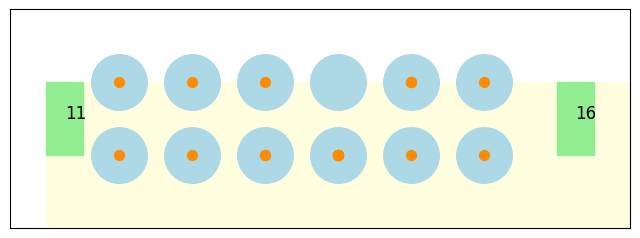

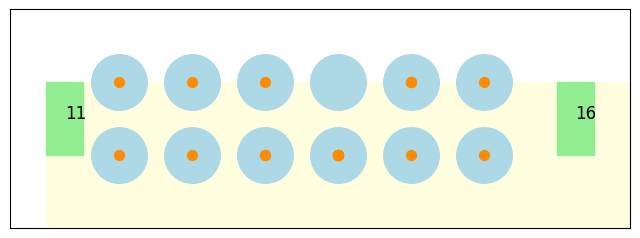

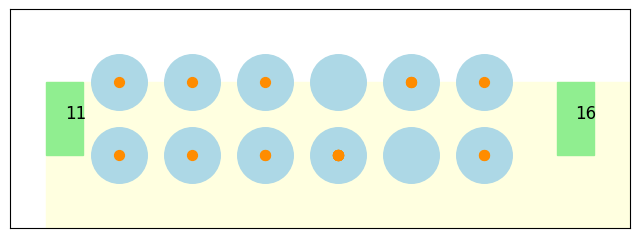

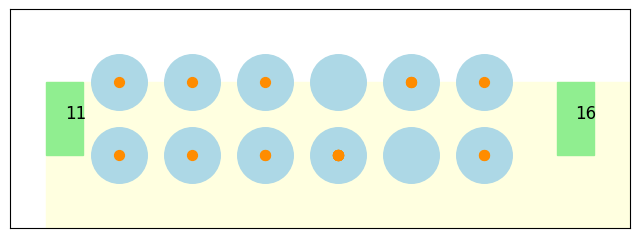

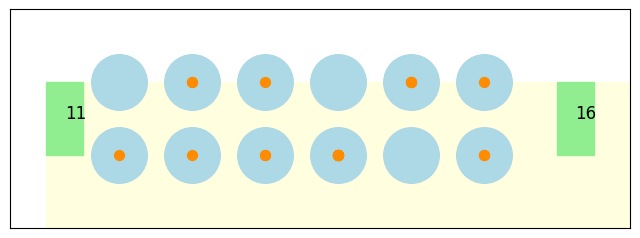

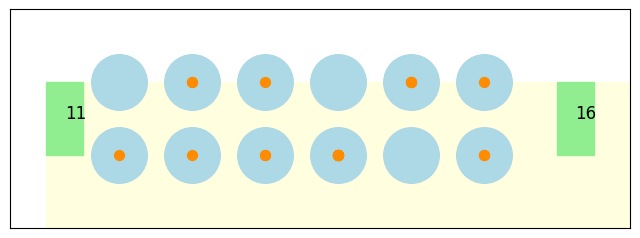

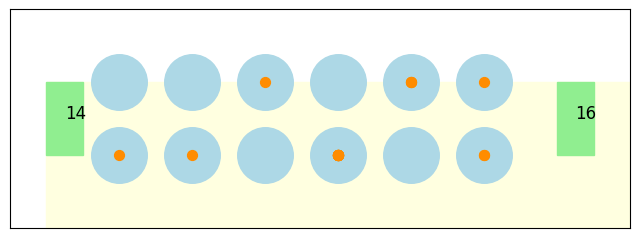

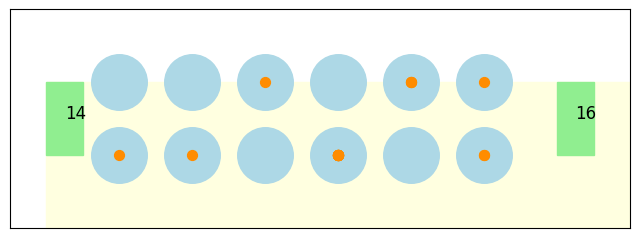

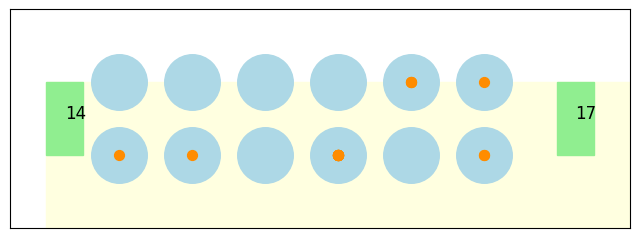

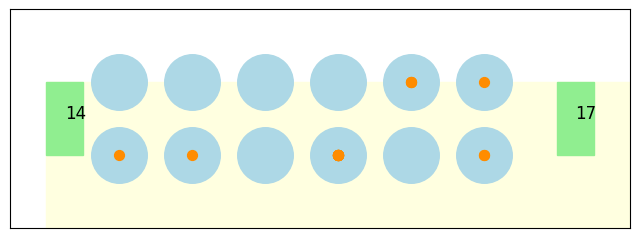

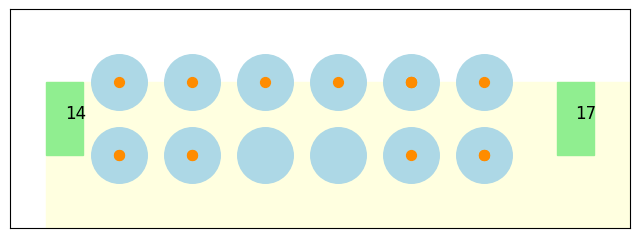

KeyboardInterrupt: 

In [4]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy

def compile_frames_to_video(frames_directory="frames", video_filename="game_simulation.mp4", fps=10):
    frame_files = sorted([f for f in os.listdir(frames_directory) if f.endswith('.png')])
    first_frame = cv2.imread(os.path.join(frames_directory, frame_files[0]))
    height, width, layers = first_frame.shape
    video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'mp4'), fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(frames_directory, frame_file))
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()

def simulate_game_mcts(episodes=1, visualize=True):
    games_data = []  
    frame_number = 0 
    for episode in range(episodes):
        game_board = MancalaBoard()
        root_node = MCTSNode(game_board)
        game_over = False

        while not game_over:
            best_move = monte_carlo_tree_search(root_node, visualize=visualize)
            last_pit = game_board.make_move(best_move, root_node.player)
            game_board.capture_seeds(last_pit, root_node.player)
            root_node = MCTSNode(game_board, player=1 - root_node.player)

            if game_board.is_game_over():
                scores = game_board.get_score()
                game_over = True
                games_data.append(scores) 

            if visualize:
                visualize_board(game_board, frame_number)
                frame_number += 1

    return games_data


def analyze_and_plot_game_data(games_data, method_name, color, results_filename="game_results.txt", plot_filename_prefix="plot"):
    total_games = len(games_data)
    player1_wins = sum(1 for score in games_data if score[0] > score[1])
    player2_wins = total_games - player1_wins
    average_score_player1 = sum(score[0] for score in games_data) / total_games
    average_score_player2 = sum(score[1] for score in games_data) / total_games

    with open(results_filename, "a") as file:
        print(f"Method: {method_name}", file=file)
        print(f"Total games played: {total_games}", file=file)
        print(f"Player 1 Wins: {player1_wins} ({player1_wins/total_games*100:.2f}%)", file=file)
        print(f"Player 2 Wins: {player2_wins} ({player2_wins/total_games*100:.2f}%)", file=file)
        print(f"Average Score Player 1: {average_score_player1:.2f}", file=file)
        print(f"Average Score Player 2: {average_score_player2:.2f}", file=file)
        print("", file=file)

    # Plotting
    plt.bar(method_name + ' Player 1 Wins', player1_wins / total_games, color=color)
    plt.bar(method_name + ' Player 2 Wins', player2_wins / total_games, color=color)
    plt.bar(method_name + ' Avg Score P1', average_score_player1, color=color)
    plt.bar(method_name + ' Avg Score P2', average_score_player2, color=color)

    plt.savefig(f"{plot_filename_prefix}_{method_name}.png")

    plt.show()


def visualize_board(board, frame_number, frames_directory="frames"):
    fig, ax = plt.subplots(figsize=(8, 3))

    ax.clear()
    ax.set_aspect('equal')

    ax.add_patch(plt.Rectangle((-1, -1), 12, 2, color='lightyellow', zorder=0))

    pit_positions = [(i % 6, 0 if i < 6 else 1) for i in range(12)]
    pit_x, pit_y = zip(*pit_positions)
    ax.scatter(pit_x, pit_y, s=1600, color='lightblue', zorder=1)

    seed_x, seed_y = [], []
    for i in range(12):
        for _ in range(board.board[i]):
            seed_x.append(i % 6)
            seed_y.append(0 if i < 6 else 1)
    ax.scatter(seed_x, seed_y, s=50, color='darkorange', zorder=2)

    ax.add_patch(plt.Rectangle((-1, 0), 0.5, 1, color='lightgreen', zorder=1))
    ax.text(-0.75, 0.5, f'{board.stores[0]}', fontsize=12)
    ax.add_patch(plt.Rectangle((6, 0), 0.5, 1, color='lightgreen', zorder=1))
    ax.text(6.25, 0.5, f'{board.stores[1]}', fontsize=12)

    plt.xticks([])
    plt.yticks([])
    ax.set_xlim(-1.5, 7)
    ax.set_ylim(-1, 2)

    if not os.path.exists(frames_directory):
        os.makedirs(frames_directory)

    plt.savefig(f"{frames_directory}/frame_{frame_number:03d}.png")
    plt.show()
    plt.close(fig)
    

    
class MancalaBoard:
    def __init__(self):
        self.board = [4] * 12
        self.stores = [0, 0]  # Two stores

    def make_move(self, pit_index, player):
        # Pick up all seeds from the selected pit
        num_seeds = self.board[pit_index]
        self.board[pit_index] = 0
        current_index = pit_index

        while num_seeds > 0:
            current_index = (current_index + 1) % 12
            if (player == 0 and current_index == 11) or (player == 1 and current_index == 5):
                continue
            self.board[current_index] += 1
            num_seeds -= 1

        return current_index

    def capture_seeds(self, last_pit_index, player):
        if self.board[last_pit_index] == 1:
            opposite_index = 11 - last_pit_index
            captured_seeds = self.board[opposite_index] + 1  # Capture opposite seeds plus the last seed
            self.stores[player] += captured_seeds
            self.board[opposite_index] = 0
            self.board[last_pit_index] = 0

    def is_game_over(self):
        side1_empty = all(seeds == 0 for seeds in self.board[:6])
        side2_empty = all(seeds == 0 for seeds in self.board[6:])
        return side1_empty or side2_empty

    def get_score(self):
        self.stores[0] += sum(self.board[:6])
        self.stores[1] += sum(self.board[6:])
        self.board = [0] * 12  # Clear the board
        return self.stores

    def __str__(self):
        return (f"Player 1 Store: {self.stores[0]} | " +
                " ".join(str(s) for s in self.board[:6][::-1]) + '\n' +
                " ".join(str(s) for s in self.board[6:]) + f" | Player 2 Store: {self.stores[1]}")

mancala_board = MancalaBoard()
print(mancala_board)

class MCTSNode:
    def __init__(self, board, move=None, parent=None, player=0):
        self.board = board
        self.move = move
        self.parent = parent
        self.player = player
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_moves = self.get_legal_moves()
        self.is_terminal_node = board.is_game_over()

    def get_legal_moves(self):
        moves = []
        if self.player == 0:
            for i in range(6):
                if self.board.board[i] != 0:
                    moves.append(i)
        else:
            for i in range(6, 12):
                if self.board.board[i] != 0:
                    moves.append(i)
        return moves

    def expand(self):
        move = self.untried_moves.pop()
        new_board = copy.deepcopy(self.board)
        last_pit = new_board.make_move(move, self.player)
        new_board.capture_seeds(last_pit, self.player)
        child_node = MCTSNode(new_board, move=move, parent=self, player=1 - self.player)
        self.children.append(child_node)
        return child_node

    def update(self, result):
        self.visits += 1
        if self.player == 0:
            self.wins += result[0] > result[1]
        else:
            self.wins += result[1] > result[0]

    def select_child(self):
        ucb1_values = [
            (child.wins / child.visits) + math.sqrt(2 * math.log(self.visits) / child.visits)
            for child in self.children
        ]
        return self.children[ucb1_values.index(max(ucb1_values))]

def simulate_random_game(start_board):
    # Simulates a random game from the given start board state
    board = copy.deepcopy(start_board)
    player = 0
    while not board.is_game_over():
        possible_moves = [i for i in range(6) if board.board[i] != 0] if player == 0 else [i for i in range(6, 12) if board.board[i] != 0]
        move = random.choice(possible_moves)
        last_pit = board.make_move(move, player)
        board.capture_seeds(last_pit, player)
        player = 1 - player
    return board.get_score()

def monte_carlo_tree_search(root, visualize=True):
    frame_number = 0  # Initialize frame counter
    for _ in range(100):  # Number of simulations
        node = root
        board = copy.deepcopy(root.board)

        while not node.untried_moves and node.children:
            node = node.select_child()
            last_pit = board.make_move(node.move, node.player)
            board.capture_seeds(last_pit, node.player)

        if node.untried_moves:
            node = node.expand()

        result = simulate_random_game(board)

        while node is not None:
            node.update(result)
            node = node.parent

    best_move_node = sorted(root.children, key=lambda c: c.visits)[-1]
    if visualize:
        visualize_board(best_move_node.board, frame_number)
        frame_number += 1
    return best_move_node.move




test_board = MancalaBoard()
root_node = MCTSNode(test_board)
best_move = monte_carlo_tree_search(root_node)
print(f"Best move determined by MCTS: {best_move}")

class QLearningAgent:
    def __init__(self, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.alpha = alpha   
        self.gamma = gamma      
        self.epsilon = epsilon  
        self.Q = {}            

    def get_Q_value(self, state, action):
        return self.Q.get((state, action), 0)

    def set_Q_value(self, state, action, value):
        self.Q[(state, action)] = value

    def choose_action(self, state, legal_actions):
        if np.random.random() < self.epsilon:
            return np.random.choice(legal_actions)
        else:
            Q_values = [self.get_Q_value(state, a) for a in legal_actions]
            max_Q = max(Q_values)
            actions_with_max_Q = [a for a, q in zip(legal_actions, Q_values) if q == max_Q]
            return np.random.choice(actions_with_max_Q)

    def learn(self, state, action, reward, next_state, next_legal_actions):
        next_max = max([self.get_Q_value(next_state, a) for a in next_legal_actions]) if next_legal_actions else 0
        self.Q[(state, action)] = (1 - self.alpha) * self.get_Q_value(state, action) + \
                                  self.alpha * (reward + self.gamma * next_max)

def state_from_board(board):
    return str(board.board + board.stores)

test_agent = QLearningAgent()
test_board = MancalaBoard()
state = state_from_board(test_board)
action = test_agent.choose_action(state, [0, 1, 2, 3, 4, 5])
print(f"Chosen action by Q-learning agent: {action}")
def simulate_game_q_learning(agent, episodes=1, visualize=True):
    games_data = [] 
    frame_number = 0
    for episode in range(episodes):
        game_board = MancalaBoard()
        game_over = False
        turn = 0

        while not game_over:
            state = state_from_board(game_board)
            legal_actions = [i for i in range(6) if game_board.board[i + 6*turn] != 0]
            action = agent.choose_action(state, legal_actions)

            last_pit = game_board.make_move(action + 6*turn, turn)
            game_board.capture_seeds(last_pit, turn)

            if game_board.is_game_over():
                scores = game_board.get_score()
                game_over = True
                games_data.append(scores)

            if visualize:
                visualize_board(game_board, frame_number)
                frame_number += 1

            turn = 1 - turn

    return agent, games_data 
mcts_data = simulate_game_mcts(episodes=100)
analyze_and_plot_game_data(mcts_data, "MCTS", 'pink')

q_learning_agent = QLearningAgent()
_, q_learning_data = simulate_game_q_learning(q_learning_agent, episodes=1000)
analyze_and_plot_game_data(q_learning_data, "Q-Learning", 'blue')


compile_frames_to_video()
